**Multi-Class Classification**. 
***Contents*** 
1. Importing Libraries
2. Creating list of .npy files
3. CustomDataset and DataLoaders
4. Model
5. Creating Modelfit
6. AND Finally Ploting the ROC_CURVE and AUC scores

In [1]:
# creating a dir "best_model" for saving the best model during training 
!mkdir best_model

# 1. Libraries

In [2]:
# importing all the libraries
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  Dataset  , DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
class CONFIG():
    
    EPOCHS = 30
    
    cwd = "/kaggle/input"
    
    # path in which the best model will be saved 
    BEST_MODEL_PATH = os.getcwd() + "/best_model/model.pth"
    pathTRAIN = cwd + "/lensdata/dataset/train/"
    pathVAL = cwd + "/lensdata/dataset/val/"
    
    batch_size = 32
    lr = 1e-4
    num_workers = 4
    num_class = 3
    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def create_npy_list():
    Lens = ['no' , 'sphere' , 'vort'] #List of all lens classes
    train_paths = []
    val_paths = []
    lens = 0 # the index for the lens class
    for i in Lens:
        _ , _ , lists_train_npy = next(os.walk('/kaggle/input/lensdata/dataset/train/'+ i))
        for l in range(len(lists_train_npy)):
            lists_train_npy[l] = i + "/" + lists_train_npy[l]
            train_paths.append((lists_train_npy[l] , lens))
        _ , _ , lists_val_npy = next(os.walk('/kaggle/input/lensdata/dataset/val/'+ i))
        for l in range(len(lists_val_npy)):
            lists_val_npy[l] = i + "/" + lists_val_npy[l]
            val_paths.append((lists_val_npy[l] , lens))
        lens+=1
    return train_paths , val_paths

train_paths , val_paths = create_npy_list() 

In [5]:
print(f"The Length of training dataset: {len(train_paths)}")
print(f"The Length of valid dataset: {len(val_paths)}")

The Length of training dataset: 30000
The Length of valid dataset: 7500


# Custom Dataset

In [6]:
transform = transforms.Compose(
    
            [
                transforms.ToPILImage(),
                transforms.RandomVerticalFlip(0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1), 
                transforms.RandomGrayscale(p=0.2),
                transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
                transforms.ToTensor()
                
            ]
        )

In [7]:
class dataset(Dataset):
    def __init__(self , train, files ):
        self.files = files # files contains the list of sub paths of all .npy files
        self.train = train # a bool value to set 'dir' to train or val dataset's path
    def __len__(self):
        length = len(self.files)
        return length
    
    def __getitem__(self , idx):
        if self.train:
            dir = CONFIG.pathTRAIN # path of the trained dataset 
        else:
            dir = CONFIG.pathVAL # path of validation dataset
            
        path , lens = self.files[idx] 
        PATH = dir + path
        image = np.load(PATH)
        image = torch.from_numpy(image)
        if self.train:
            image = transform(image)
        return image , lens                 #lens is either 0('no') , 1('sphere') , 2('vort')

In [8]:
train_data = dataset( train = True , files = train_paths)
val_data = dataset(train = False , files = val_paths)

In [9]:
# data loaders
train_loader = DataLoader(train_data , batch_size = CONFIG.batch_size ,  shuffle = True, num_workers = CONFIG.num_workers )
valid_loader = DataLoader(val_data , batch_size = CONFIG.batch_size , shuffle = True, num_workers = CONFIG.num_workers )

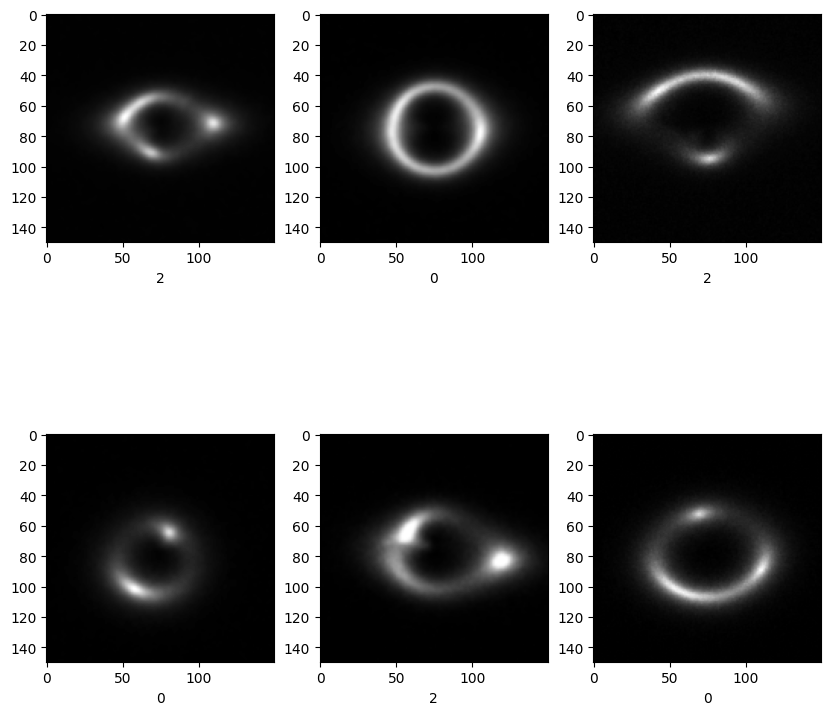

In [10]:
#ploting a few of the images

fig = plt.figure(figsize= (10,10))
for n , data in enumerate(train_loader):
    image = data[0]
    image = image[0][0]
    fig.add_subplot(2 , 3 , n +1)
    plt.imshow(image , cmap='gray')
    plt.xlabel(data[1][0].numpy())
    if n==5:
        break
plt.show()
# 0 -> no
# 1 -> sphere
# 2 vort

# Model

I've used efficietnet_b5 with its pretrained Weights and have latter add a few of Linear layers. Adding custom linear layers on top of the pre-trained EfficientNet model is a good approach to fine-tune the model for a specific task. I've tried using many models like resnet , vgg but the best reuslts were given by efficientnets, I used efficientnet_b1 and efficientnet_b3, EfficientNet B5 may rquire more training time but ultimately provide better accuracy compared to the B1 and B3 models.

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.num_classes = CONFIG.num_class
        self.model = models.efficientnet_b5(weights = True)
        self.model.features[0][0] = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)      
        
        self.model.classifier[1] = nn.Sequential(
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512, 256),
                                nn.ReLU(),
                                nn.Linear(256 , self.num_classes)
                                        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
model = Model().to(CONFIG.DEVICE) #setting the model to device in this case cuda.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 154MB/s]


# CREATING Modelfit

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.lr)
criterion = nn.CrossEntropyLoss()

In [14]:
def train_epoch(criterion , data_loader):
    total_Loss = 0
    total_accuracy = 0 
    model.train()

    for n , (img , lens) in tqdm(enumerate(data_loader) , total=len(data_loader)) : 
        if CONFIG.DEVICE == 'cuda':
            img = img.type(torch.cuda.FloatTensor)  #img is of shape (batch_size , 1 , 150 , 150)
        else:
            img = img.type(torch.FloatTensor)
        lens = lens.to(CONFIG.DEVICE)                      #lens --||--(batch_size)
    
    # forward 
        score = model(img)                          #score --||-- (lens.shape , 3) 
        loss = criterion(score , lens)
        total_Loss += loss
    
        _ , lens_idx = score.max(1)  
        correct_preds = (lens_idx == lens).float()
        acc = correct_preds.sum() / len(correct_preds)
        acc = (acc)*100
        total_accuracy += acc
        
    # backward
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    size = len(data_loader) 
    total_accuracy /= size
    total_Loss /= (size)
    return total_Loss.detach().cpu().numpy() , total_accuracy.detach().cpu().numpy()

In [15]:
def val_epoch(val_loader):
  model.eval()
  total_loss = 0 
  total_accuracy = 0
  with torch.no_grad():
    for i , ( img , y ) in tqdm(enumerate(val_loader) , total=(len(val_loader))):
      if CONFIG.DEVICE == 'cuda':
            img = img.type(torch.cuda.FloatTensor)
      else:
            img = img.type(torch.FloatTensor)
      y =y.to(CONFIG.DEVICE)
    
      score = model(img)
      loss = criterion(score , y)
      total_loss+= loss
    
      _ , lens = score.max(1)
      correct_preds = (lens == y).float()
      acc = correct_preds.sum() / len(correct_preds)
      acc = (acc)*100
      total_accuracy += acc
        
    size = len(val_loader)
    total_loss /= size
    total_accuracy /= size
    return total_loss.detach().cpu().numpy() , total_accuracy.detach().cpu().numpy()


In [16]:
def Modelfit(train_loader , valid_loader):
    EPOCHS = CONFIG.EPOCHS
    best_loss = 10
    for epochs in range(EPOCHS):
        
       print("Epochs {}/{} ".format(epochs + 1  , EPOCHS))
    
       train_loss , accuracy = train_epoch(criterion , train_loader)
        
       valid_loss , val_accuracy = val_epoch(valid_loader)
       
       tqdm.write(f"train loss: {train_loss}   valid_loss: {valid_loss}" )
    
       tqdm.write(f"train accuracy: {accuracy}  valid_accuracy: {val_accuracy}")
       
       if epochs == 1:
            best_loss = 10 
       if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict() , CONFIG.BEST_MODEL_PATH) #saving the best model 
       
Modelfit(train_loader , valid_loader)

Epochs 1/30 


100%|██████████| 235/235 [00:18<00:00, 12.52it/s]


train loss: 0.9987305998802185   valid_loss: 0.9043552279472351
train accuracy: 46.298641204833984  valid_accuracy: 54.516841888427734
Epochs 2/30 


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


train loss: 0.6182394027709961   valid_loss: 0.643862247467041
train accuracy: 73.86393737792969  valid_accuracy: 73.4352798461914
Epochs 3/30 


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


train loss: 0.44345006346702576   valid_loss: 0.4725199043750763
train accuracy: 82.77919006347656  valid_accuracy: 81.51152801513672
Epochs 4/30 


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


train loss: 0.3569326400756836   valid_loss: 0.37161922454833984
train accuracy: 86.4372329711914  valid_accuracy: 85.54521179199219
Epochs 5/30 


100%|██████████| 235/235 [00:18<00:00, 12.68it/s]


train loss: 0.3040212392807007   valid_loss: 0.31030675768852234
train accuracy: 88.75933074951172  valid_accuracy: 88.26240539550781
Epochs 6/30 


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


train loss: 0.270539790391922   valid_loss: 0.2901614010334015
train accuracy: 90.2618637084961  valid_accuracy: 89.86701965332031
Epochs 7/30 


100%|██████████| 235/235 [00:18<00:00, 12.65it/s]


train loss: 0.25016629695892334   valid_loss: 0.27458542585372925
train accuracy: 91.02812194824219  valid_accuracy: 90.28368377685547
Epochs 8/30 


100%|██████████| 235/235 [00:18<00:00, 12.63it/s]


train loss: 0.2312479168176651   valid_loss: 0.2588336169719696
train accuracy: 91.73441314697266  valid_accuracy: 90.36790466308594
Epochs 9/30 


100%|██████████| 235/235 [00:18<00:00, 12.65it/s]


train loss: 0.21347078680992126   valid_loss: 0.22349628806114197
train accuracy: 92.3674087524414  valid_accuracy: 91.91931915283203
Epochs 10/30 


100%|██████████| 235/235 [00:18<00:00, 12.68it/s]

train loss: 0.20192722976207733   valid_loss: 0.24163705110549927
train accuracy: 92.94376373291016  valid_accuracy: 91.50708770751953
Epochs 11/30 



100%|██████████| 235/235 [00:18<00:00, 12.66it/s]


train loss: 0.1940689980983734   valid_loss: 0.22206911444664001
train accuracy: 93.16697692871094  valid_accuracy: 91.94149017333984
Epochs 12/30 


100%|██████████| 235/235 [00:18<00:00, 12.66it/s]


train loss: 0.18355931341648102   valid_loss: 0.19115059077739716
train accuracy: 93.59342193603516  valid_accuracy: 93.4973373413086
Epochs 13/30 


100%|██████████| 235/235 [00:18<00:00, 12.68it/s]

train loss: 0.17198944091796875   valid_loss: 0.20496033132076263
train accuracy: 93.9299087524414  valid_accuracy: 92.92996215820312
Epochs 14/30 



100%|██████████| 235/235 [00:18<00:00, 12.67it/s]

train loss: 0.16569530963897705   valid_loss: 0.19638198614120483
train accuracy: 94.07649230957031  valid_accuracy: 93.24910736083984
Epochs 15/30 



100%|██████████| 235/235 [00:18<00:00, 12.64it/s]

train loss: 0.15937025845050812   valid_loss: 0.19781233370304108
train accuracy: 94.64952087402344  valid_accuracy: 92.98314666748047
Epochs 16/30 



100%|██████████| 235/235 [00:18<00:00, 12.68it/s]

train loss: 0.15354137122631073   valid_loss: 0.19427147507667542
train accuracy: 94.72281646728516  valid_accuracy: 93.39095306396484
Epochs 17/30 



100%|██████████| 235/235 [00:18<00:00, 12.64it/s]

train loss: 0.14749620854854584   valid_loss: 0.19227057695388794
train accuracy: 94.86273956298828  valid_accuracy: 94.08244323730469
Epochs 18/30 



100%|██████████| 235/235 [00:18<00:00, 12.66it/s]


train loss: 0.1411908119916916   valid_loss: 0.1851559728384018
train accuracy: 95.1659164428711  valid_accuracy: 93.7101058959961
Epochs 19/30 


100%|██████████| 235/235 [00:18<00:00, 12.66it/s]


train loss: 0.13587737083435059   valid_loss: 0.17625375092029572
train accuracy: 95.32916259765625  valid_accuracy: 94.15779876708984
Epochs 20/30 


100%|██████████| 235/235 [00:18<00:00, 12.64it/s]


train loss: 0.13222171366214752   valid_loss: 0.1761920005083084
train accuracy: 95.58901977539062  valid_accuracy: 94.27748107910156
Epochs 21/30 


100%|██████████| 235/235 [00:18<00:00, 12.59it/s]


train loss: 0.1323326826095581   valid_loss: 0.1675378829240799
train accuracy: 95.48241424560547  valid_accuracy: 94.42819213867188
Epochs 22/30 


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


train loss: 0.12452816963195801   valid_loss: 0.15072430670261383
train accuracy: 95.85887908935547  valid_accuracy: 94.95123291015625
Epochs 23/30 


100%|██████████| 235/235 [00:18<00:00, 12.66it/s]

train loss: 0.12196466326713562   valid_loss: 0.15528376400470734
train accuracy: 95.85554504394531  valid_accuracy: 94.83155822753906
Epochs 24/30 



100%|██████████| 235/235 [00:18<00:00, 12.66it/s]

train loss: 0.1166740208864212   valid_loss: 0.1537959724664688
train accuracy: 96.05876922607422  valid_accuracy: 94.58776092529297
Epochs 25/30 



100%|██████████| 235/235 [00:18<00:00, 12.64it/s]

train loss: 0.11542493849992752   valid_loss: 0.16376790404319763
train accuracy: 95.99214172363281  valid_accuracy: 94.77393341064453
Epochs 26/30 



100%|██████████| 235/235 [00:18<00:00, 12.66it/s]

train loss: 0.11088406294584274   valid_loss: 0.19156941771507263
train accuracy: 96.34194946289062  valid_accuracy: 94.61878967285156
Epochs 27/30 



100%|██████████| 235/235 [00:18<00:00, 12.64it/s]

train loss: 0.11191719025373459   valid_loss: 0.16582129895687103
train accuracy: 96.2020263671875  valid_accuracy: 94.96453094482422
Epochs 28/30 



100%|██████████| 235/235 [00:18<00:00, 12.63it/s]


train loss: 0.10796654969453812   valid_loss: 0.147476926445961
train accuracy: 96.33195495605469  valid_accuracy: 94.8448486328125
Epochs 29/30 


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


train loss: 0.10469914972782135   valid_loss: 0.1406514048576355
train accuracy: 96.36194610595703  valid_accuracy: 95.46542358398438
Epochs 30/30 


100%|██████████| 235/235 [00:18<00:00, 12.64it/s]

train loss: 0.09822756797075272   valid_loss: 0.15340839326381683
train accuracy: 96.6218032836914  valid_accuracy: 95.31914520263672


* Loading The Best model

In [17]:
model.load_state_dict(torch.load(CONFIG.BEST_MODEL_PATH))

<All keys matched successfully>

# Ploting the ROC Curve and AUC score

**Evaluating the best_model on the Validation dataset**

In [18]:
true_y = []
pred_y = []
y_pred_prob_list = []
for n , (img , y) in enumerate(valid_loader):
    img = img.to(CONFIG.DEVICE)
    img = img.type(torch.cuda.FloatTensor)
    score = model(img)
    y_pred_prob_list.append(torch.softmax(score, dim = 1).detach().cpu().numpy())
    _ , lens = torch.max(score , dim=1)
    pred_y.append(lens.detach().cpu().numpy())
    true_y.append(y.detach().cpu().numpy())

In [19]:
true = []
for i in true_y:
    for j in i:
        true.append(j)
prob = []
for i in y_pred_prob_list:
    for j in (i) :     
         prob.append(j)
pred = []
for i in pred_y:
    for j in i:
        pred.append(j)

Ploting the confusion Metrics

<Axes: >

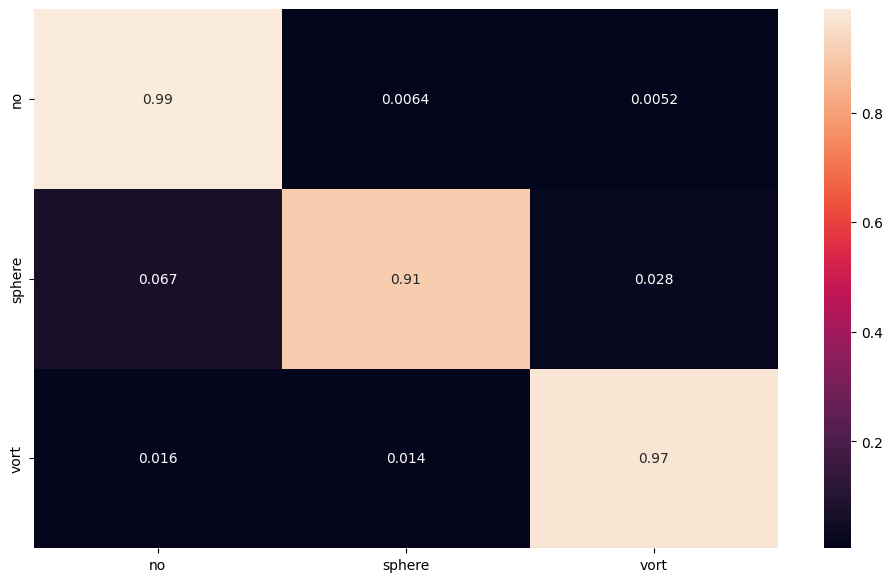

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
classes = ('no', 'sphere', 'vort')

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [21]:
fpr = { }
tpr = { }
roc_auc = { }
thresh ={ }

n_class = 3

for i in range(n_class):    
     fpr[i], tpr[i], thresh[i] = metrics.roc_curve(np.array(true), np.array(prob)[:,i], pos_label=i)
     roc_auc[i] = metrics.auc(fpr[i], tpr[i])

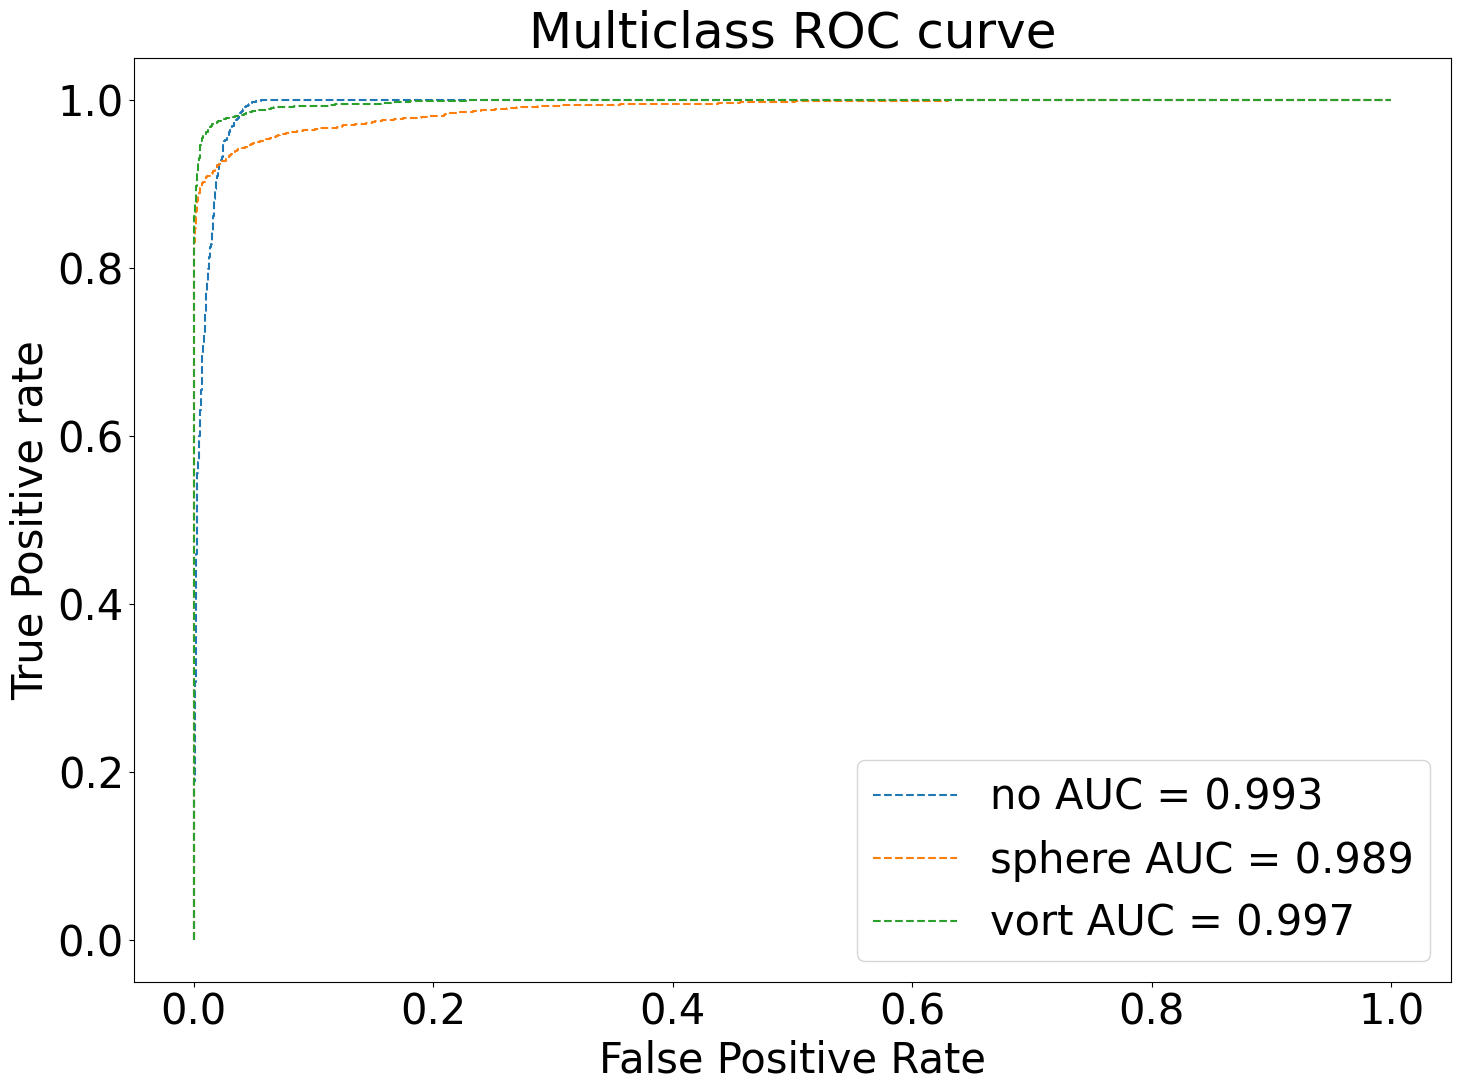

In [22]:
classes = ['no' , 'sphere' , 'vort']
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '30'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{classes[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

The model gave the best accuracy of 95.33% on the validation dataset.
The ROC_Curve is plotted and AUC scores are all > 0.99.Training the model with more epochs can give accuracy of 99% on trainig dataset but the vaidation accuracy will wonder around 95. 

**FuturScope**

Various Vision Transformers have gained popularity around computer vision tasks such as classification and segmentation. Such ViTs can extract both local and global features. These abilities can be leveraged to perform classification tasks on lensing data as further scope one might also consider physics-based informed ViT architecture which has already shown promising results.

*Reference*

[Deep Learning the Morphology of Dark Matter Substructure](https://arxiv.org/abs/1909.07346)